# Analysis of Vessel Emission Data

## Introduction
This notebook demonstrates some analysis of carbon emission data for ships. The data can be downloaded from the [EU-MRV system](https://mrv.emsa.europa.eu/#public/emission-report). 

In this notebook I will be focusing on the following four questions:

* How many ships of each type are included in the dataset?
* How do the emissions profiles differ for the different ship types?
* What is the relationship between ship deadweight and emissions intensity?
* How many miles did each vessel in the database travel?

Questions that I would like to explore in the future are:

* Which ships stopped being operated? Is there a correlation between a vessel's efficiency and if it is still being operated? 
* [This report](https://cedelft.eu/publications/estimated-index-values-of-new-ships/) details the guidelines for the EDI. It would be interesting to plot the current data set together with these values for the guidelines. 
* The dataset at hand does not contain the build years of the ships. However, we can get these from https://www.vesselfinder.com. It would be interesting to plot the efficiency values against build years for different vessel types, in particular in combination with the emission guidelines.

## Background Knowlege
Before I started this analysis, I did not know a lot about ships, so I had to look up some information to be able to make better sense of the data. Here are some explanations that a reader unfamiliar with the field might find useful.

### Vocabulary

* **Ro-Ro** is an acronym for Roll-on/roll-off. Roll-on/roll-off ships are vessels that are used to carry wheeled cargo.
* A **ropax ferry** is a ship that combines the features of a cruise ship and night cabins with a roll-on/roll-off ferry
* **Deadweight tonnage**, also known as deadweight or tons deadweight and abbreviated to **DWT** is a measure of how much weight a ship can carry. It is the sum of the weights of cargo, fuel, fresh water, ballast water, provisions, passengers, and crew. DWT is often used to specify a ship's maximum permissible deadweight (i.e. when it is fully loaded so that its Plimsoll line is at water level), although it may also denote the actual DWT of a ship not loaded to capacity (from [Wikipedia](https://en.wikipedia.org/wiki/Deadweight_tonnage)).
* **EIV** - estimated index value, simplified version of EEDI (see below)
* **EEDI** - Energy Efficiency Design Index (see below)
* **EEXI** - Energy Efficiency Existing Ship Index

### Carbon Intensity Measurements
The EIV (Estimated Index Value) is a simpliefied version of the EEDI (Energy Efficiency Design Index). Both measure the design efficiency (CO2 emissions per transported weight and distance) of new ships and do not require any measurement or reporting of true CO2 emissions while the ship is in operation. EEXI (Energy Efficiency Existing Ship Index) is the sister to EEDI. However, EEDI is applied to new ships while EEXI applies to existing vessels. As we will see later, the dataset contains both EIV and EEDI values, but no EEXI values.

### Further Reading:

* https://cedelft.eu/publications/estimated-index-values-of-new-ships/
* https://www.linkedin.com/pulse/basics-eexi-from-2023-all-existing-ships-must-meet-new-ossi-mett%25C3%25A4l%25C3%25A4/?trackingId=TBT3%2FhgIRtuQmK6s%2F2S4Zg%3D%3D
* https://www.linkedin.com/pulse/dont-plow-against-sea-currents-ossi-mett%25C3%25A4l%25C3%25A4/

## Technical Implementation 

Comments

* Whilst I would normally recommend migrating all the code into its own repositiry, the code is deliberately kept in the notebook to make it as stand-alone as possible (without having to spin up a docker container).

## Loading Libraries

As always, we start by loading the required libraries and defining any constants we might need.

In [10]:
import pathlib
import re
from enum import Enum

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.core.interactiveshell import InteractiveShell
from pandas_flavor import register_dataframe_method

import jupyter_black
import black

jupyter_black.load(
    lab=True,
    line_length=100,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)


InteractiveShell.ast_node_interactivity = "all"  # display all cell output
pio.renderers.default = (
    "jupyterlab+notebook+plotly_mimetype"  # make plotly render in jupyterlab
)

%load_ext autoreload
%autoreload 2

DATAFOLDER = pathlib.Path().cwd() / "data" / "external"


@register_dataframe_method
def display_fully(df):
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 2000)
    pd.set_option("display.float_format", "{:20,.2f}".format)
    pd.set_option("display.max_colwidth", None)
    display(df)
    pd.reset_option("display.max_rows")
    pd.reset_option("display.max_columns")
    pd.reset_option("display.width")
    pd.reset_option("display.float_format")
    pd.reset_option("display.max_colwidth")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_8516/1122084224.py:36: UserWarning:

registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'display_fully' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.



Let's set up some classes that will help us keep the code reasonably clean and reproducible.

The class structures are not perfect and could be improved with more time, but for this exploration they will have to do.

In [11]:
class Ship(str, Enum):
    imo = "ship_imo_number"
    year = "ship_reporting_period"
    name = "ship_name"
    type = "ship_ship_type"
    shipname = "ship_name"
    efficiency_type = "ship_technical_efficiency_type"
    efficiency_value = "ship_technical_efficiency_value"

    def __str__(self) -> str:  # makes enum values duck-type to strings
        return str.__str__(self)


class AnnualReport(str, Enum):
    co2_per_dwt_distance = "annual_monitoring_results_annual_average_fuel_consumption_per_transport_work_(dwt)_[g_/_dwt_carried_·_n_miles]"
    co2_per_distance = "annual_monitoring_results_annual_average_co₂_emissions_per_distance_[g_co₂_/_n_mile]"
    fuel_per_distance = "annual_monitoring_results_annual_average_fuel_consumption_per_distance_[kg_/_n_mile]"
    fuel_total = "annual_monitoring_results_total_fuel_consumption_[m_tonnes]"
    dwt_carried = "annual_monitoring_results_annual_average_dwt_carried"
    distance_total = "annual_monitoring_results_total_distance[n_mile]"
    distance_total_imputed_mean = (
        "annual_monitoring_results_total_distance[n_mile]_imputed_mean"
    )
    distance_total_imputed_median = (
        "annual_monitoring_results_total_distance[n_mile]_imputed_median"
    )

    def __str__(
        self,
    ) -> str:  # makes enum values duck-type to strings, needed for graphs
        return str.__str__(self)


class EmissionsData:
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def test_data_quality(self) -> None:
        self._assert_entries_are_unique()
        self._assert_technical_efficiency_is_not_negative()

    def _assert_entries_are_unique(self) -> None:
        # TODO: convert to logging
        print("Checking if all IMO entries are unique")
        assert (
            len(
                self.data.groupby([Ship.imo, Ship.year], as_index=False)
                .size()
                .query("size > 1")
            )
            == 0
        )
        print("- OK")

    def _assert_technical_efficiency_is_not_negative(self) -> None:
        # TODO: convert to logging
        print("\nChecking if all efficiency values are non-negativ.")
        assert len(self.data[self.data[Ship.efficiency_value].fillna(0) < 0]) == 0
        print("- OK")


class DataLoader:
    # TODO: Tidy
    def _load_df_from_file(filename: pathlib.PosixPath) -> pd.DataFrame:
        df = pd.read_excel(filename, header=[0, 2], engine="openpyxl")
        df.columns = [c.replace(" ", "_").lower() for c in df.columns.map("_".join)]

        df[[Ship.efficiency_type, Ship.efficiency_value]] = df[
            "ship_technical_efficiency"
        ].str.extract(r"(.*) \((.*) gCO₂\/t·nm\)")

        df = df.astype({Ship.efficiency_value: float, Ship.year: str})

        # data cleaning
        df[AnnualReport.co2_per_dwt_distance] = df[
            AnnualReport.co2_per_dwt_distance
        ].replace("Division by zero!", np.nan)

        df[AnnualReport.fuel_per_distance] = df[AnnualReport.fuel_per_distance].replace(
            "Division by zero!", np.nan
        )

        # convert co2 per distance to from kg to g for consistency with other variables
        df[AnnualReport.co2_per_distance] = (
            df[
                "annual_monitoring_results_annual_average_co₂_emissions_per_distance_[kg_co₂_/_n_mile]"
            ]
            * 1000
        )

        df = df.drop(
            columns=[
                "annual_monitoring_results_annual_average_co₂_emissions_per_distance_[kg_co₂_/_n_mile]",
            ],
            axis=1,
        )

        # add dwt carried for Q3
        df["annual_monitoring_results_annual_average_dwt_carried"] = (
            df[AnnualReport.co2_per_distance] / df[AnnualReport.co2_per_dwt_distance]
        )

        # add distances for Q4
        df[AnnualReport.distance_total] = (
            df[AnnualReport.fuel_total] / df[AnnualReport.fuel_per_distance]
        )

        df[AnnualReport.distance_total_imputed_mean] = df[
            AnnualReport.distance_total
        ].fillna(df.groupby(Ship.imo)[AnnualReport.distance_total].transform("mean"))

        df[AnnualReport.distance_total_imputed_median] = df[
            AnnualReport.distance_total
        ].fillna(df.groupby(Ship.imo)[AnnualReport.distance_total].transform("median"))

        print(f"Loaded {filename} containing {df.shape[0]} entries")
        return df

    def load_folder(folder: pathlib.PosixPath) -> EmissionsData:
        filenames = list(folder.glob("*.xlsx"))
        print(f"Processing {len(filenames)} files.")

        return EmissionsData(
            data=pd.concat(
                [DataLoader._load_df_from_file(filename) for filename in filenames]
            )
        )

Let's load the data and make sure it passes the data quality checks

In [3]:
dataset = DataLoader.load_folder(DATAFOLDER)

# make sure data is ok
dataset.test_data_quality()

Processing 4 files.


/home/walkenho/.cache/pypoetry/virtualenvs/emissionsanalysis-HrIjsyvU-py3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loaded /home/walkenho/repositories/nautical_carbon_emission_analysis/data/external/2020-v183-22022023-EU MRV Publication of information.xlsx containing 12046 entries


/home/walkenho/.cache/pypoetry/virtualenvs/emissionsanalysis-HrIjsyvU-py3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loaded /home/walkenho/repositories/nautical_carbon_emission_analysis/data/external/2019-v211-07102022-EU MRV Publication of information.xlsx containing 12395 entries


/home/walkenho/.cache/pypoetry/virtualenvs/emissionsanalysis-HrIjsyvU-py3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loaded /home/walkenho/repositories/nautical_carbon_emission_analysis/data/external/2018-v268-06102022-EU MRV Publication of information.xlsx containing 12256 entries


/home/walkenho/.cache/pypoetry/virtualenvs/emissionsanalysis-HrIjsyvU-py3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



Loaded /home/walkenho/repositories/nautical_carbon_emission_analysis/data/external/2021-v128-22022023-EU MRV Publication of information.xlsx containing 12213 entries
Checking if all IMO entries are unique
- OK

Checking if all efficiency values are non-negativ.
- OK


How many entries do we have?

In [4]:
dataset.data.shape

(48910, 69)

Let's dump the data into a datafame for less typing.

In [5]:
df = dataset.data

## How many Ships of each type are there?

Let's start with some basic questions. How many ships are there in total and how does this look like on a year-to-year basis?

In [6]:
n_ships = len(df[Ship.imo].drop_duplicates())

print(f"There is a total of {n_ships} unique ships in the dataset.")

There is a total of 18275 unique ships in the dataset.


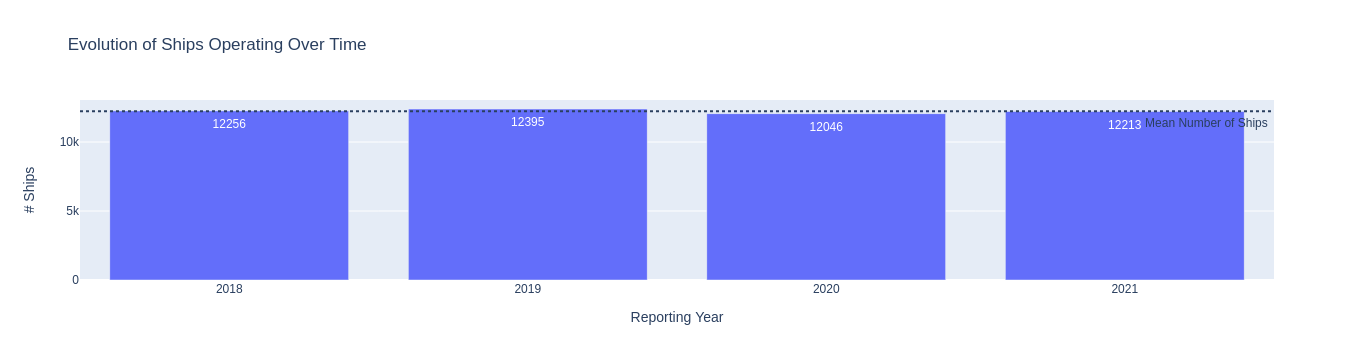

In [7]:
fig = px.bar(
    df[[Ship.imo, Ship.year]].groupby(Ship.year, as_index=False).size(),
    x=Ship.year,
    y="size",
    labels={
        Ship.year: "Reporting Year",
        "size": "# Ships",
    },
    title="Evolution of Ships Operating Over Time",
    text="size",
)
_ = fig.add_hline(
    df.groupby(Ship.year).size().mean(),
    line_dash="dot",
    annotation_text="Mean Number of Ships",
    annotation_position="bottom right",
)
_ = fig.update_traces(textposition="inside")
fig.show()

The number of ships increased in 2019 in comparison to 2018, then fell in 2020. It has recovered in 2021, but is still below the numbers in both 2018 and 2019. However, the changes are relatively small in comparison the overall number of ships operating. I wonder if these fluctuations are to be expected or if the uncertainties of the pandemic and the [start of the second phase of EEDI in 2020](https://www.linkedin.com/pulse/basics-eexi-from-2023-all-existing-ships-must-meet-new-ossi-mett%25C3%25A4l%25C3%25A4/?trackingId=TBT3%2FhgIRtuQmK6s%2F2S4Zg%3D%3D) are having an influence here.

### Looking More Granularly: Is there a particular ship type whos numbers have been particularly growing or shrinking?

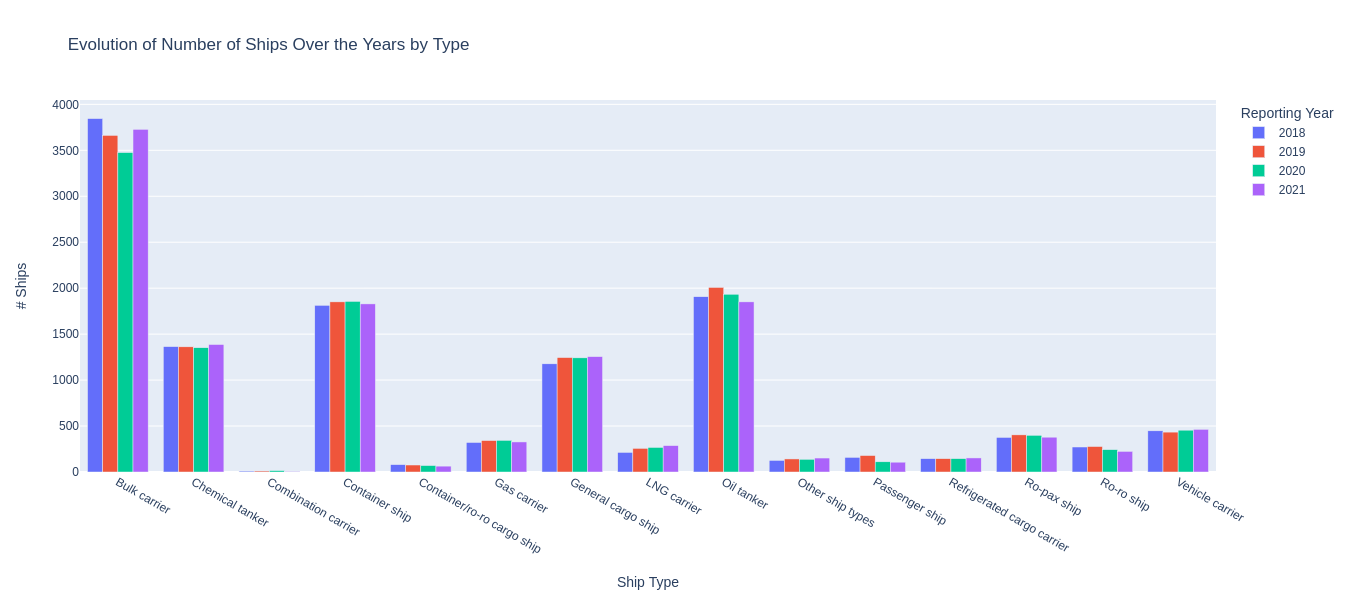

In [8]:
px.bar(
    df.astype({"ship_reporting_period": str})
    .groupby(["ship_reporting_period", "ship_ship_type"], as_index=False)
    .size(),
    x=Ship.type,
    y="size",
    color=Ship.year,
    barmode="group",
    labels={
        Ship.type: "Ship Type",
        "size": "# Ships",
        Ship.year: "Reporting Year",
    },
    title="Evolution of Number of Ships Over the Years by Type",
    height=600,
)

There does not seem to be any particular type of ship which has been changing its numbers. Maybe bulk carriers, which have been decreasing in numbers till 2020, but have recovered in 2021. But nothing too extra-ordinary.

Let's have a look at overall distribution of ship types in a given year.

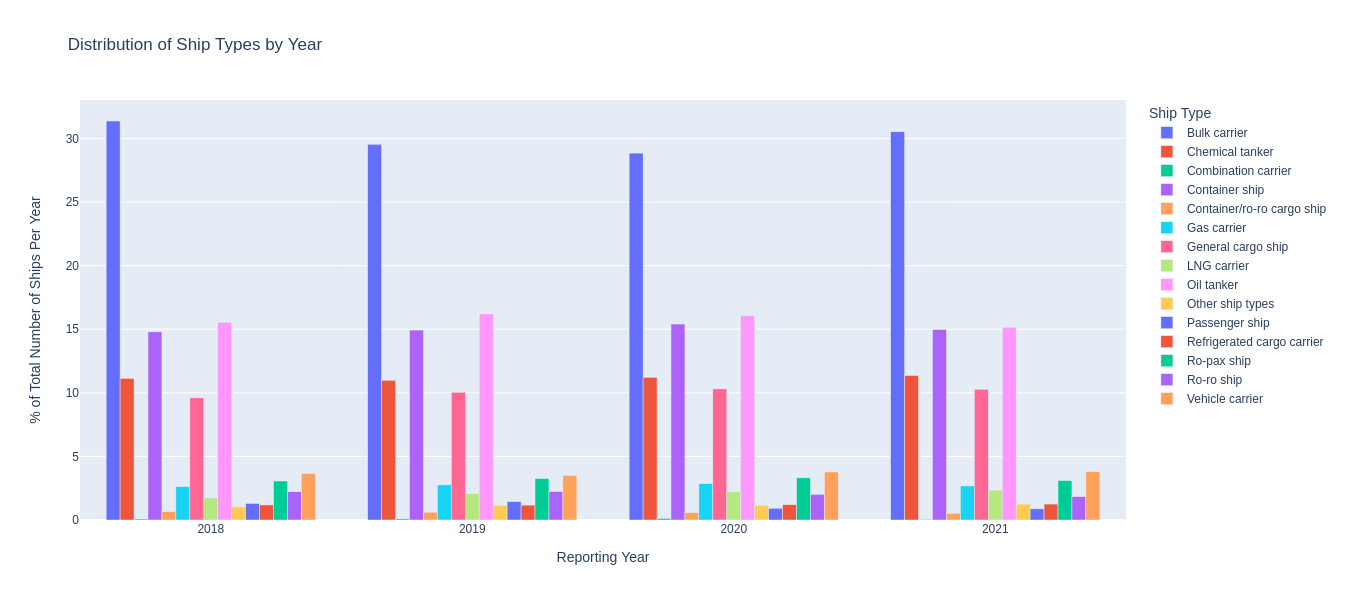

In [9]:
px.bar(
    df.groupby([Ship.year, Ship.type], as_index=False)
    .size()
    .assign(
        percentage=lambda df: df["size"]
        / df.groupby(Ship.year)["size"].transform(sum)
        * 100
    ),
    x=Ship.year,
    y="percentage",
    color=Ship.type,
    barmode="group",
    labels={
        Ship.type: "Ship Type",
        "percentage": "% of Total Number of Ships Per Year",
        Ship.year: "Reporting Year",
    },
    title="Distribution of Ship Types by Year",
    height=600,
)

Here, we again see that bulk carriers had been loosing influence, but have been regaining traction. It also seems that there are slightly fewer oil tankers.

I was wondering what the operating patterns of ships were. Once they are operating, do they keep on operating every year or do they have breaks (particularly in the wake of the pandemic)? What about the ship type? Is it permanently assigned or does it change every so often?

### Does a given ship keep on operating or does it pause for years in between?

The following table counts the number of ships that operate for any given set of years.

In [10]:
pd.DataFrame(
    df[[Ship.imo, Ship.year]]
    .groupby(Ship.imo, as_index=False)[Ship.year]
    .apply(lambda x: ", ".join(sorted(x)))
).groupby(Ship.year, as_index=False).size().sort_values(
    by="size", ascending=False
).rename(
    columns={Ship.year: "Reporting Periods", "size": "number_of_ships"}
).reset_index(
    drop=True
)

Reporting Periods  number_of_ships
0   2018, 2019, 2020, 2021             6414
1                     2021             1479
2                     2018             1453
3         2019, 2020, 2021             1371
4         2018, 2019, 2020             1215
5               2018, 2019             1191
6               2020, 2021             1020
7                     2019              708
8         2018, 2019, 2021              697
9                     2020              642
10        2018, 2020, 2021              531
11              2019, 2020              529
12              2018, 2021              431
13              2018, 2020              324
14              2019, 2021              270

As we can see, most ships have been operating for all four years that we have data for.

The second place (albeit with a huge distance) is taken by ships that have just started operating in 2021, followed by ships that have stopped operating in 2018.

### Is a ship type permanently assigned to a ship or does it change?

If we want to answer the question "How many ships of each type are there in total in our dataset?", we need to make sure that each ship is only counted for a single ship type. So let's see if ships change their types. 

In [11]:
imos_with_multiple_shiptypes = (
    df[[Ship.imo, Ship.type]]
    .drop_duplicates()
    .groupby("ship_imo_number", as_index=False)
    .size()
    .query("size>1")["ship_imo_number"]
    .values
)

n_ships_with_multiple_types = len(imos_with_multiple_shiptypes)
print(
    f"There are {n_ships_with_multiple_types} ships with multiple types in the dataset, which makes about {round(n_ships_with_multiple_types/n_ships*100)}%"
)

There are 399 ships with multiple types in the dataset, which makes about 2%


Let's look at which other ship-types co-occur for the same ship.  

In [12]:
pd.DataFrame(
    pd.DataFrame(
        df[df[Ship.imo].isin(imos_with_multiple_shiptypes)]
        .sort_values(by=[Ship.imo, Ship.type])
        .groupby(Ship.imo, as_index=False)[Ship.type]
        .apply(lambda x: ", ".join(sorted(set(x))))
    )
    .groupby(Ship.type, as_index=False)
    .size()
).sort_values(by="size", ascending=False).reset_index(drop=True).rename(
    columns={Ship.type: "Ship Types", "size": "number of ships"}
)

Ship Types  number of ships
0                         Chemical tanker, Oil tanker              110
1                General cargo ship, Other ship types               71
2                         Ro-ro ship, Vehicle carrier               58
3                    Bulk carrier, General cargo ship               52
4                            Gas carrier, LNG carrier               19
5                  Container ship, General cargo ship               17
6              Container/ro-ro cargo ship, Ro-ro ship               12
7                      Bulk carrier, Other ship types                8
8          Container ship, Container/ro-ro cargo ship                7
9        Other ship types, Refrigerated cargo carrier                5
10                   Container ship, Other ship types                5
11            Combination carrier, General cargo ship                5
12                        Passenger ship, Ro-pax ship                4
13                      LNG carrier, Other ship types                3
14                  Chemical tanker, Other ship types                2
15  Container ship, General cargo ship, Other ship...                2
16                  Other ship types, Vehicle carrier                2
17                      Bulk carrier, Vehicle carrier                2
18                       Oil tanker, Other ship types                2
19  Combination carrier, General cargo ship, Other...                1
20                       Ro-pax ship, Vehicle carrier                1
21                       Other ship types, Ro-ro ship                1
22   Bulk carrier, Container ship, General cargo ship                1
23  Bulk carrier, General cargo ship, Other ship t...                1
24                            LNG carrier, Oil tanker                1
25                     General cargo ship, Ro-ro ship                1
26                            Gas carrier, Oil tanker                1
27         Gas carrier, LNG carrier, Other ship types                1
28                    Chemical tanker, Container ship                1
29                       Bulk carrier, Container ship                1
30                         Container ship, Oil tanker                1
31                      Bulk carrier, Chemical tanker                1

Without being an industry expert, a lot of the more frequently occuring combinations look very reasonable to me. Some examples going from more to less frequent:

* I could imagine that it might be easy to use a ship as an oil tanker one year and a chemical tanker another year.
* A ro/ro (roll-on/roll-off) carrier can easily transport vehicles, so it seems reasonable to use it as a vehicle carrier.
* Is there actually a difference between a bulk carrier, a general cargo ship and a container ship?
* LNG is a type of Gas, so an LNG carrier is a specific type of Gas carrier.
    
So how do you assign one type to each ship? This definitely depends on why exactly you want to know the total number of ships in the dataset for. Some options of how to clean the data are:

* Ignore the fact that some ships appear multiple times. Maybe you just don't care about the 2%. 
* Assign to each ship the mode of its types (one disadvantage here being that if there is a draw, you still have to use an additional method). 
* Assign to each ship its latest type.
* Four counting purposes, if you don't mind having non-integer counts, you could also break each ship down by the number of years it was used as each type. For example a ship used three years as chemical tanker and one year as oil tanker, would add 0.75 to the count of chemical tankers and 0.25 to the count of oil tankers.
* Finally, if we are not bound to the original ship types, we could re-cast the ship types into easier to handle categories or create a ship-type embedding based on type similarity. 

For each of the techniques above, one might want to ignore the "other ship types" category. The ship type field is always populated, which indicates that "Other ship types" is the default category and should be treated as a Nan and filled in accordingly.

Without any further information, in order to count the overall number of ships, I treat "Other ship types" as NaN and then use latest known type to standardize the data.

In [13]:
df_cleaned_shiptypes = df.copy()

df_cleaned_shiptypes[Ship.type] = df_cleaned_shiptypes[Ship.type].replace(
    "Other ship types", np.nan
)

df_cleaned_shiptypes = df_cleaned_shiptypes.sort_values(
    by=[Ship.imo, Ship.year]
).assign(
    ship_ship_type_standardized=lambda df: df.groupby(Ship.imo, as_index=False)[
        Ship.type
    ]
    .transform("last")
    .fillna("Unkown")
)

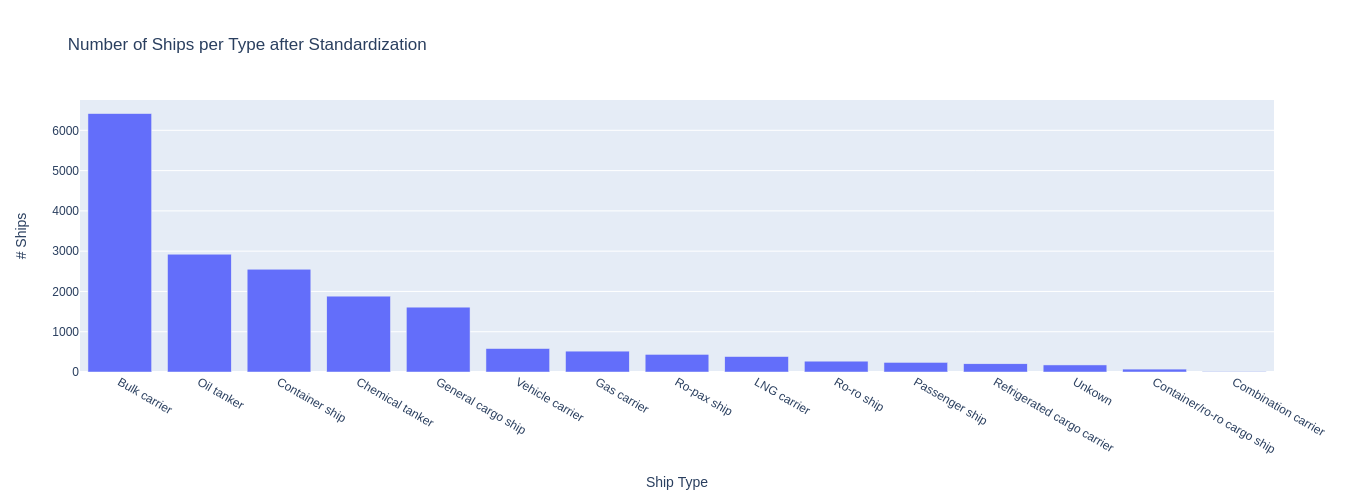

In [14]:
px.bar(
    df_cleaned_shiptypes[[Ship.imo, "ship_ship_type_standardized"]]
    .drop_duplicates()
    .groupby("ship_ship_type_standardized", as_index=False)
    .size()
    .sort_values(by="size", ascending=False),
    x="ship_ship_type_standardized",
    y="size",
    labels={"ship_ship_type_standardized": "Ship Type", "size": "# Ships"},
    title="Number of Ships per Type after Standardization",
    height=500,
)

It might also be interesting to look at how the ships change between different types. We have already seen that specific types seem to co-occur more frequently. Does the conversion mostly happen in a given direction or are they converted back, too? A transition matrix would be a good visualization type for this type of question.

However, for the moment, this goes beyond the scope of this exercise.

## How do the emissions profiles differ for the different ship types?

Here, I investigate how the technical efficiency changes looks for different ship types. There are two technical efficiency types that can be found in the dataset:

* [EIV - (estimated index value)](https://cedelft.eu/publications/estimated-index-values-of-new-ships/)
* [EEDI- Energy Efficiency Design Index](https://www.sustainable-ships.org/rules-regulations/eedi)

Both EIV and EEDI measure the CO2 emissions per transported weight and distance. 

### EVI Profile

In [15]:
df_evi = df[df[Ship.efficiency_type] == "EIV"][
    [
        Ship.imo,
        Ship.name,
        Ship.type,
        Ship.year,
        Ship.efficiency_type,
        Ship.efficiency_value,
    ]
].sort_values(by=[Ship.year, Ship.type])

Let's look at the EVI values by ship type, split by year. Splitting by year might  help us to distinguish between outliers due to data entry issues and outliers due to potentially extra-ordinary vessels. 

* only there for one year? -> probably an outlier due to data entry issues
* value exists for multiple years -> maybe an extraordinary vessel?

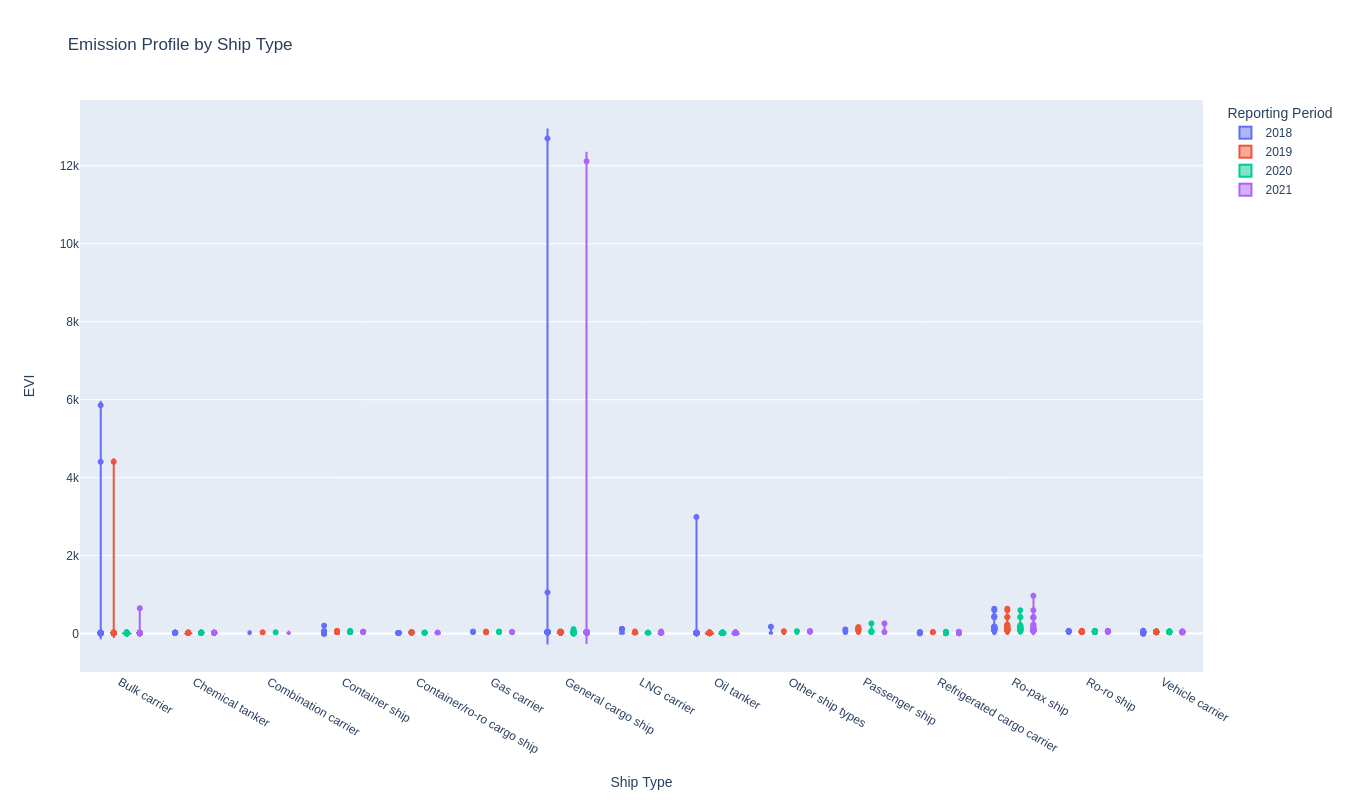

In [16]:
fig = px.violin(
    df_evi,
    x=Ship.type,
    y=Ship.efficiency_value,
    height=800,
    box=True,
    color=Ship.year,
    labels={
        Ship.efficiency_value: "EVI",
        Ship.type: "Ship Type",
        Ship.year: "Reporting Period",
    },
    title="Emission Profile by Ship Type",
)
fig.show()

Without zooming, we can see some outliers already. Let's zoom in to take a look at the different distributions.

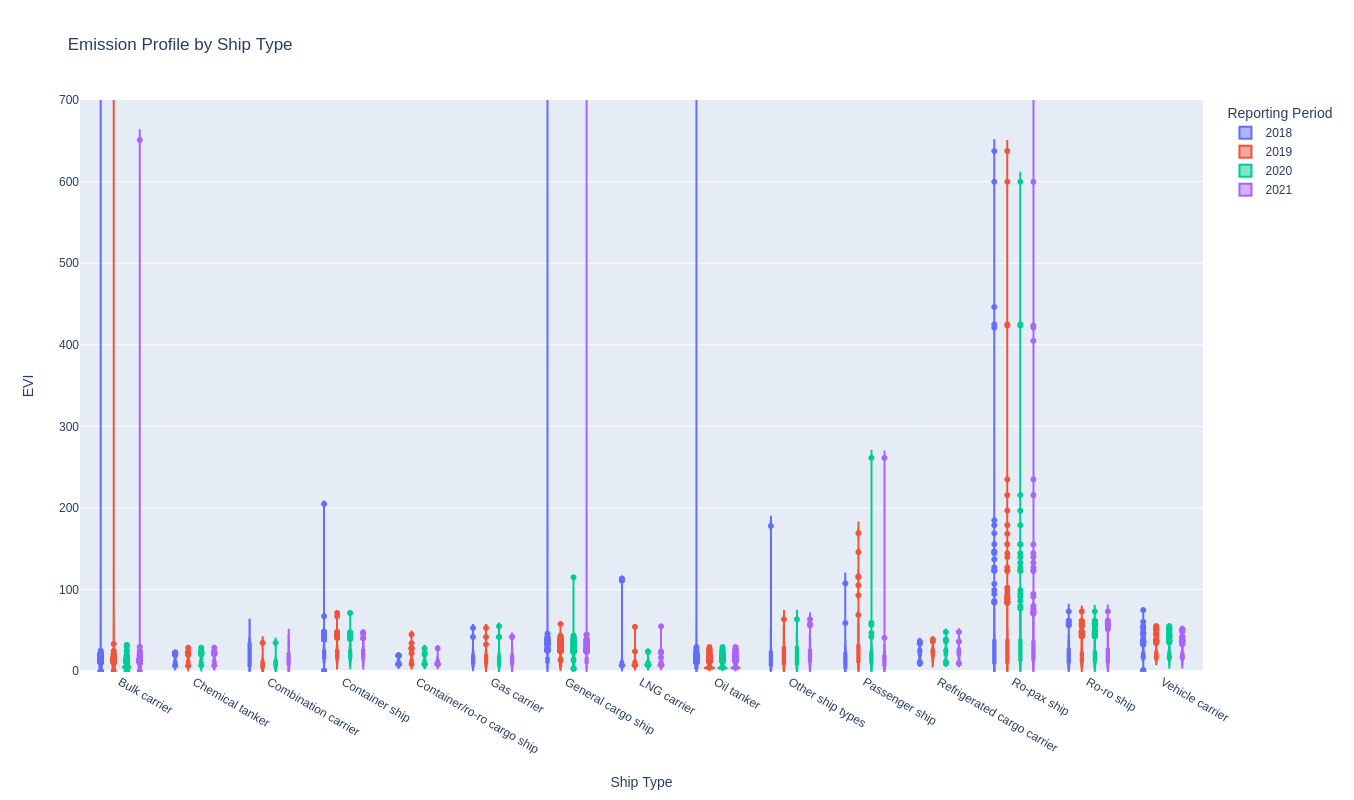

In [17]:
fig = px.violin(
    df_evi,
    x=Ship.type,
    y=Ship.efficiency_value,
    height=800,
    box=True,
    color=Ship.year,
    labels={
        Ship.efficiency_value: "EVI",
        Ship.type: "Ship Type",
        Ship.year: "Reporting Period",
    },
    title="Emission Profile by Ship Type",
)
_ = fig.update_layout(yaxis_range=[-1, 700])
fig.show()

Here, we can already start to see differences in the distributions. Whilst without digging in further, it is not clear if EVI values of above 300 for Ro-pax ships should be considered data-entry outliers or not, it is clear, that both types of passenger ships (Ro-pax ships and passenger ships) have a larger spread in possible EVI values that the other non-passenger ships.

Let's zoom in more to look at some of the other distributions.

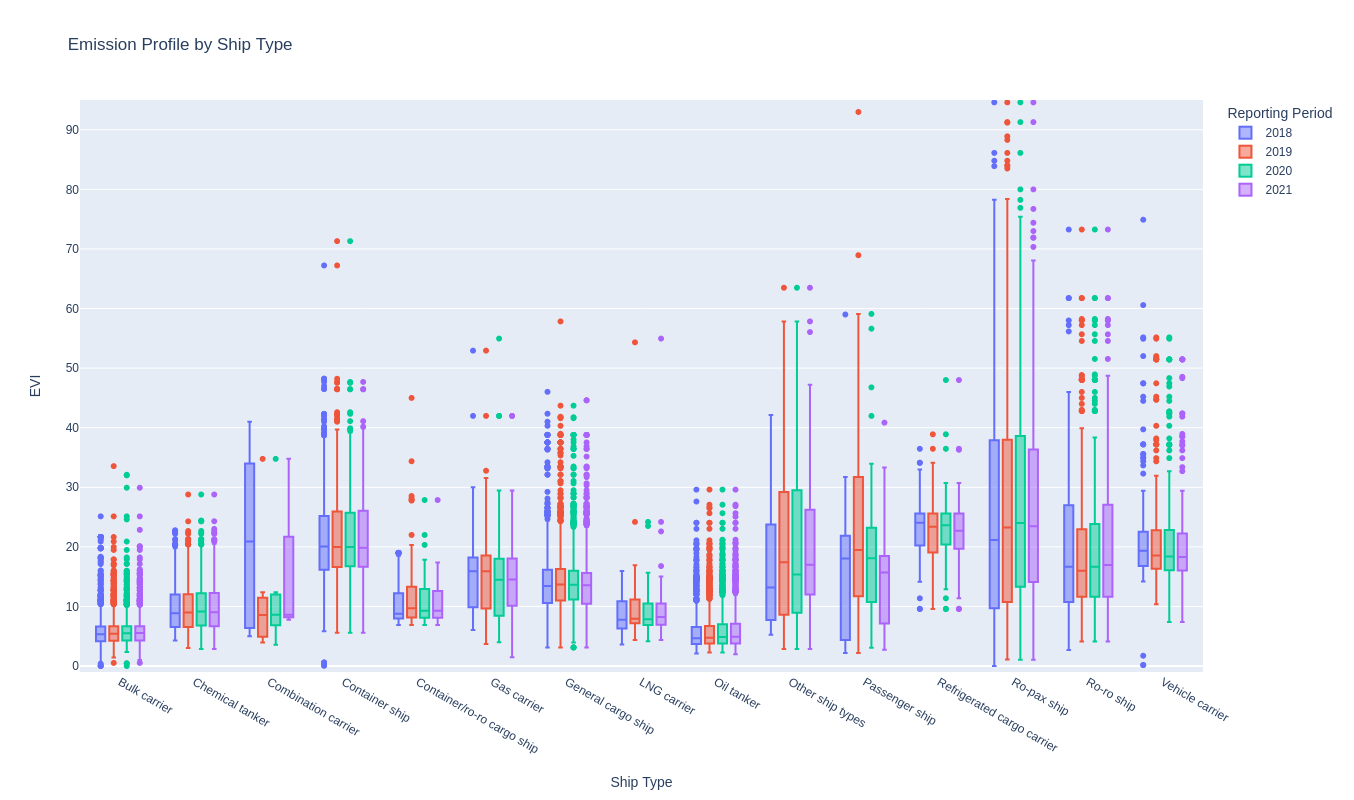

In [18]:
fig = px.box(
    df_evi,
    x=Ship.type,
    y=Ship.efficiency_value,
    height=800,
    # box=True,
    color=Ship.year,
    labels={
        Ship.efficiency_value: "EVI",
        Ship.type: "Ship Type",
        Ship.year: "Reporting Period",
    },
    title="Emission Profile by Ship Type",
)
fig.update_layout(yaxis_range=[-1, 95])

Some more observations:

* Bulk carriers have very low median EVI and small IQR values. The same is true for Oil tankers.
* Refrigerated cargo carriers have the highest median EVI. Maybe because of the extra energy required for the refrigeration?
* Against my expectation, Gas carriers do have quite different median EVIs from LNG carriers and higher IQRs. I would love to ask a business expert why this is. 
* Passenger ships (Ro-pax and Passenger) have very spread in EVI, so does "Other ship types".
* Some of the ship types have an interesting pattern to them (for example bulk carriers, general cargo ships, oil tankers). They have a gap above their 75% quartile and then more data points above it. If I had more time, I would investigate if there are other variables in this dataset that can explain this behaviour.

One thing that I would have expected is for the EVI to decrease as the reporting period increases ([as stated in this report](https://cedelft.eu/wp-content/uploads/sites/2/2021/04/CE_Delft_7E50_Estimated_Index_Values_of_New_Ships_DEF.pdf)), which is not the case when looking at the overall dataset. It would be interesting to plot the EVI in dependency on the build year of a ship (which one could get for example from [vesselfinder](https://www.vesselfinder.com/vessels)) to see if this effect can not be seen because there are not yet enough new ships in the dataset. In absence of information about the build year, one could look at the influence of the year that the vessel appeared in the dataset for the first time, but again, it is not clear if this would give more insight.  

### EEDI

In [19]:
df_eedi = df_evi = df[df[Ship.efficiency_type] == "EEDI"][
    [
        Ship.imo,
        Ship.name,
        Ship.type,
        Ship.year,
        Ship.efficiency_type,
        Ship.efficiency_value,
    ]
].sort_values(by=[Ship.year, Ship.type])

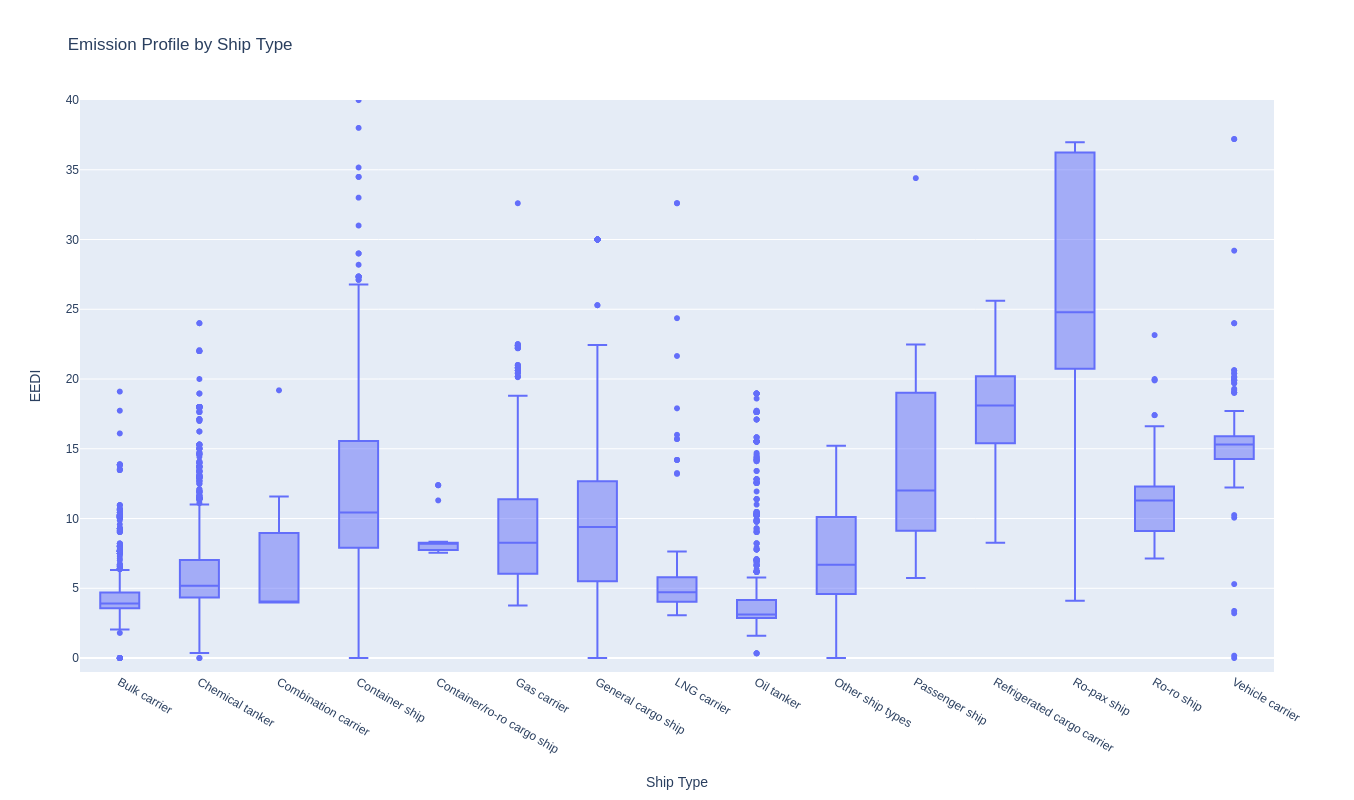

In [20]:
fig = px.box(
    df_eedi,
    x=Ship.type,
    y=Ship.efficiency_value,
    height=800,
    labels={
        Ship.efficiency_value: "EEDI",
        Ship.type: "Ship Type",
        Ship.year: "Reporting Period",
    },
    title="Emission Profile by Ship Type",
)
fig.update_layout(yaxis_range=[-1, 40])

The EEDI data shows similar trends as the EIV data.

## What is the relationship between ship Deadweight and emissions intensity?

The ship's deadweight is not directly given in the dataset, but we can calculate it as $$\mathrm{dwt} = \frac{\frac{\mathrm{CO2}}{\mathrm{distance}}}{\frac{\mathrm{CO2}}{\mathrm{dwt} \times \mathrm{distance}}}$$

I assume the following defintion of emission intensity $$\mathrm{Emission Intensity} = \frac{\mathrm{Total CO2}}{\mathrm{dwt}\times\mathrm{distance}}$$ since this seems to be the value that EVI/EEDI are interested in.

As we can see in the figure below, the relationship between Emission Intensity and Deadweight is linear on a log-log scale, which means, that the relationship itself follows a power law:

$$\mathrm{Emission Intensity} = \alpha \times\mathrm{dwt}^{\beta}$$

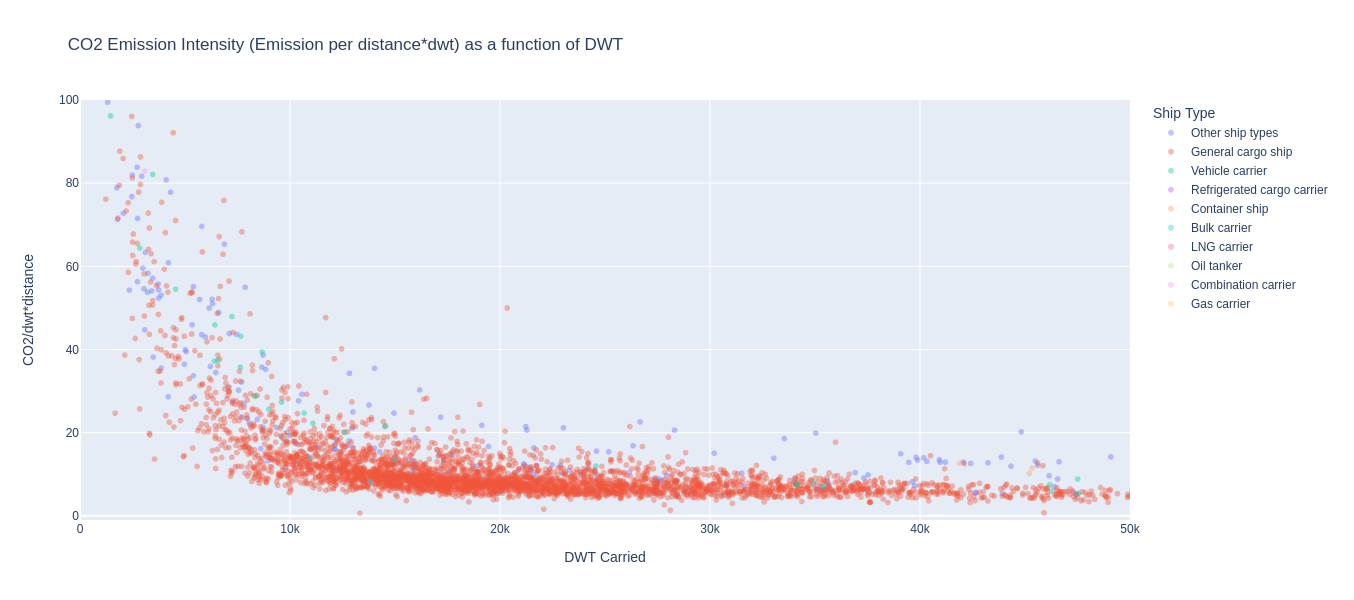

In [21]:
# filter out NaN values to not clutter up categories
df_not_na = df[(~pd.isna(df[AnnualReport.dwt_carried]))]

fig = px.scatter(
    df_not_na,
    x=AnnualReport.dwt_carried,
    y=AnnualReport.co2_per_dwt_distance,
    color=Ship.type,
    labels={
        AnnualReport.dwt_carried: "DWT Carried",
        AnnualReport.co2_per_dwt_distance: "CO2/dwt*distance",
        Ship.type: "Ship Type",
    },
    title="CO2 Emission Intensity (Emission per distance*dwt) as a function of DWT",
    height=600,
    opacity=0.4,
)
_ = fig.update_layout(xaxis_range=[-1, 0.5e5], yaxis_range=[-1, 100])
fig.show()

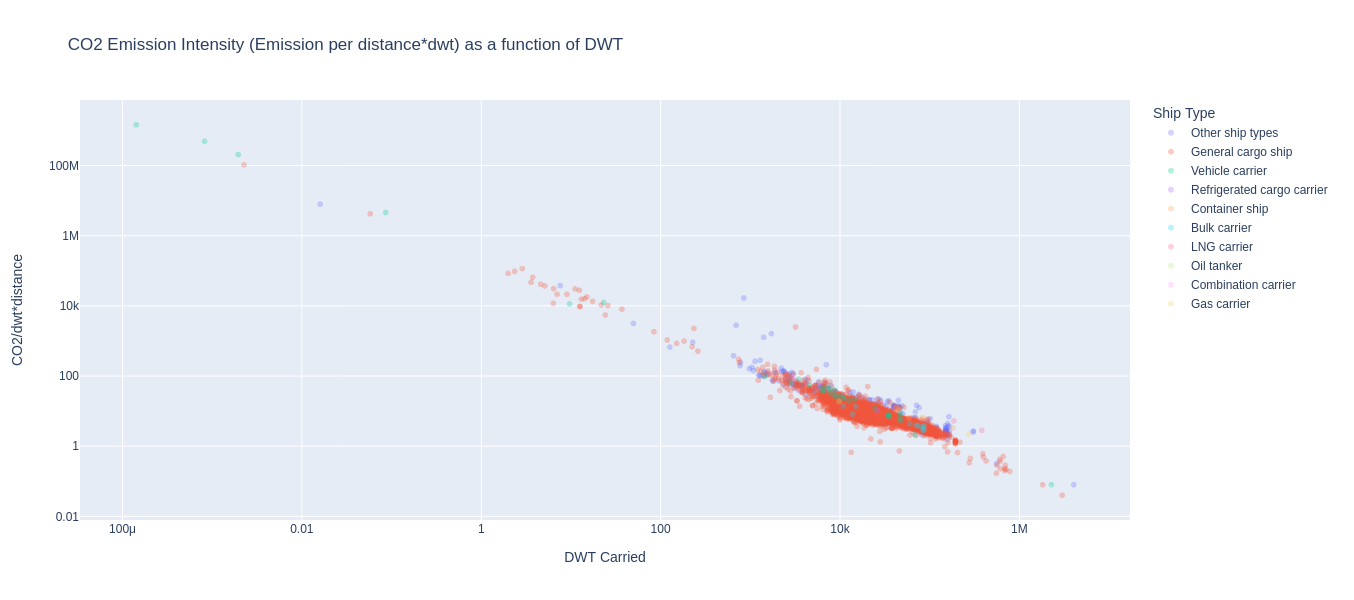

In [22]:
# filter out NaN values to not clutter up categories
df_not_na = df[(~pd.isna(df[AnnualReport.dwt_carried]))]

fig = px.scatter(
    df_not_na,
    x=AnnualReport.dwt_carried,
    y=AnnualReport.co2_per_dwt_distance,
    color=Ship.type,
    labels={
        AnnualReport.dwt_carried: "DWT Carried",
        AnnualReport.co2_per_dwt_distance: "CO2/dwt*distance",
        Ship.type: "Ship Type",
    },
    title="CO2 Emission Intensity (Emission per distance*dwt) as a function of DWT",
    height=600,
    opacity=0.3,
    log_x=True,
    log_y=True,
)
fig.show()

## How many miles did each vessel in the database travel?

In order to calculate the total amount of distance covered by a given vessel, we need to first fill in any missing values for the distance. There are two standard ways of doing this, one is imputing it using the mean, the other is imputing it using the median. Here, I will use the median.

Let's have a quick check for outliers. 

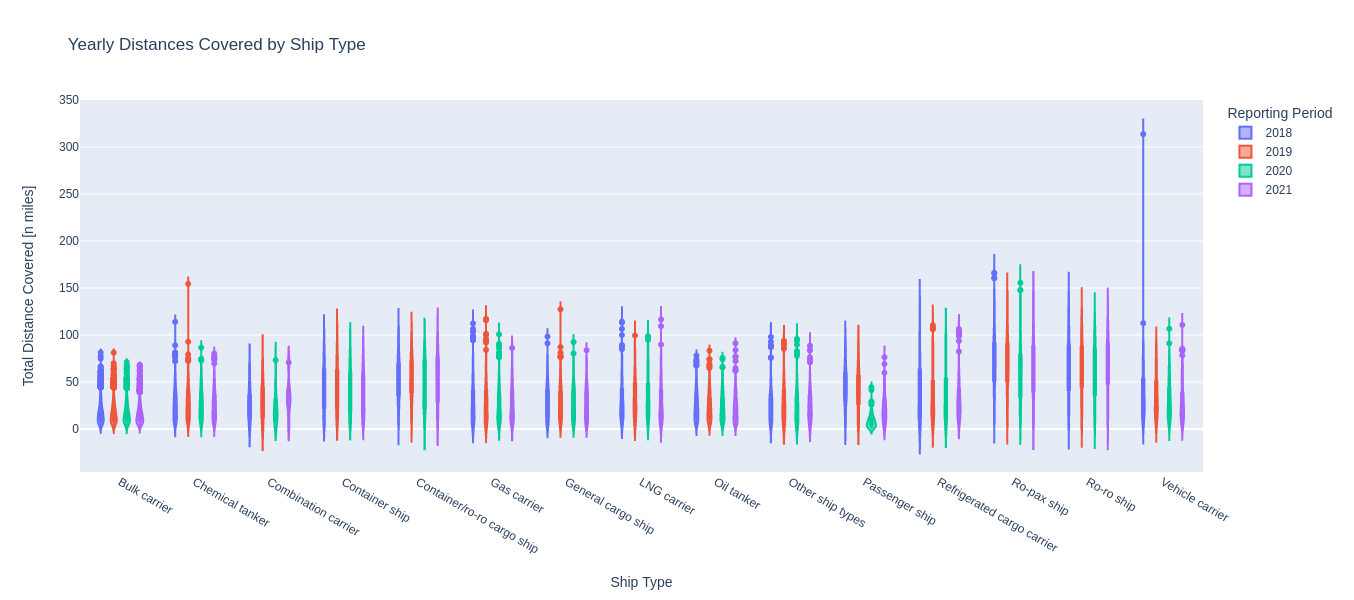

In [23]:
px.violin(
    df[[AnnualReport.distance_total, Ship.type, Ship.year]].sort_values(
        by=[Ship.year, Ship.type]
    ),
    x=Ship.type,
    y=AnnualReport.distance_total,
    color=Ship.year,
    box=True,
    height=600,
    labels={
        Ship.type: "Ship Type",
        AnnualReport.distance_total: "Total Distance Covered [n miles]",
        Ship.year: "Reporting Period",
    },
    title="Yearly Distances Covered by Ship Type",
)

There are a few potential outliers in the data as for example the vehicle carrier with about 330 nautical miles. However, none of them are too outrageous, so that all of them could potentially also just be slighly unusual behaviour. Let's keep them and only impute the values that are missing from the start. Note that even after imputation, there are still vessels without any data at all. These will just keep their NaN values.

I am not sure how to visualize this on a vessel-by-vessel basis, so instead, for the moment, I am just creating the DataFrame that holds all of the information.

I was thinking of potentially creating some visualizations of overall distance covered by vessel type. However, this would require the standardization of the vessel type as discussed in Question 2 and it seems that there are a lot of assumptions in there. So for the moment, I will just keep with the visualization above showing the yearly distances covered.

In [24]:
df_total_distance_per_ship = (
    df.groupby(Ship.imo, as_index=False)[[AnnualReport.distance_total_imputed_median]]
    .sum()
    .replace(0, np.nan)
    .sort_values(by=AnnualReport.distance_total_imputed_median)
    .reset_index(drop=True)
)

df_total_distance_per_ship

ship_imo_number  \
0              9240134   
1              9194878   
2              9875630   
3              9225043   
4              9249324   
...                ...   
18270          9859026   
18271          9861811   
18272          9884813   
18273          9905708   
18274          9924912   

       annual_monitoring_results_total_distance[n_mile]_imputed_median  
0                                               0.105403                
1                                               0.115002                
2                                               0.170398                
3                                               0.190000                
4                                               0.199001                
...                                                  ...                
18270                                                NaN                
18271                                                NaN                
18272                                                NaN                
18273                                                NaN                
18274                                                NaN                

[18275 rows x 2 columns]

## Conclusion

In this notebook I focused on answering the following four questions:

* How many ships of each type are included in the dataset?
* How do the emissions profiles differ for the different ship types?
* What is the relationship between ship deadweight and emissions intensity?
* How many miles did each vessel in the database travel?

There are more  interesting questions to ask, but for the moment, that's for the future.